# Проект Прогнозирование заказов такси: 
**Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час.**

### Цель проекта
**Разработать модель для прогнозирования количества заказов такси на следующий час.**

- **Важные критерии:**
    - Значение метрики RMSE на тестовой выборке должно быть не больше 48.


### Этапы:

#### [1. Обзор данных](#load)
- **Загрузить и проанализировать входные данные**

#### [2. Предобработка](#data_preprocessing)
- **Проверить на пропуски и дубликаты**
- **Выявить другие проблемы с данными**

#### [3. Исследовательский анализ данных (EDA)](#eda)
- **Изучить распределение признаков**
- **Провести корреляционный анализ признаков**

#### [4. Моделирование](#model)
- **Построить pipeline для выбора модели и гиперпарамиетров**
- **Провести подбор гиперпараметров моделей ElasticNet, DecisionTree, KNeighbors, SVM**
- **Оценить RMSE лучшей модели**
- **Интерпретировать результаты**

#### [8. Выводы](#conclusion)

## Описание данных
Файл `taxi.csv` содержит информацию о количестве заказов такси.  

- **datetime** — дата и время заказа  
- **num_orders** — количество заказов  

## Импорт библиотек

In [1]:
%pip install -U -q scikit-learn
%pip install phik -q
%pip install lightgbm -q
%pip install shap -q

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [2]:
import os
import warnings

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from IPython.display import display, HTML

from sklearn import set_config
from sklearn.linear_model import (
    LinearRegression,
    ElasticNet)
from sklearn.tree import DecisionTreeRegressor
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.metrics import root_mean_squared_error
from sklearn.model_selection import (
    train_test_split,
    TimeSeriesSplit,
    RandomizedSearchCV)
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import (
    OneHotEncoder,
    StandardScaler,
    MinMaxScaler,
    RobustScaler
)

from statsmodels.tsa.seasonal import seasonal_decompose

import lightgbm as lgb
from lightgbm import early_stopping

RANDOM_STATE = 42
TEST_SIZE = 0.1

In [3]:
# задаем настройки pandas
pd.set_option('display.float_format', '{:.4f}'.format)

# задаем настройки среды визуализации
%config InlineBackend.figure_format = 'jpeg' 
%matplotlib inline

sns.set(style="whitegrid", font_scale=1, rc={"figure.figsize": (8, 6)})

set_config(display="diagram")

warnings.filterwarnings('ignore')

<a id="load"></a>
## Обзор данных

In [4]:
# загружаем датасеты
pth = '/datasets/taxi.csv'
pth_alt = r"C:\Users\User\da_practicum\local_projects\11 предсказание загруженности такси\data\taxi.csv"

if os.path.exists(pth):
    data = pd.read_csv(pth, index_col=[0], parse_dates=[0])
elif os.path.exists(pth_alt):
    data = pd.read_csv(pth_alt, index_col=[0], parse_dates=[0])
else:
    print('Something is wrong')
    data = None

data.shape

(26496, 1)

In [5]:
# определим функцию для вывода общей информации о датасете
def displ(data, title='Обзорная информация', obj=True, discr=True):
    """
    Функция для вывода общей информации о датасете
    """

    print(f'----------{title}----------\n')

    display(data.info())
    print(f'-------Датафрейм-------\n')
    display(data.head(5))
    if discr:
        print(f'-------Описательные статистики для количественных признаков-------\n')
        display(data.describe().T)
    if obj:
        print(f'-------Описательные статистики для категориальных признаков-------\n')
        display(data.describe(include='object').T)
    
    #определене пропусков
    print(f'-------Количество и процент пропусков-------\n')
    print(data.isna().sum())

    # монотонность индексов
    print(f'-------Проверка монотонности индексов-------\n')
    print(data.index.is_monotonic)

In [6]:
displ(data, obj=False)

----------Обзорная информация----------

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


None

-------Датафрейм-------



,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


-------Описательные статистики для количественных признаков-------



,count,mean,std,min,25%,50%,75%,max
num_orders,26496.0000,14.0705,9.2113,0.0000,8.0000,13.0000,19.0000,119.0000


-------Количество и процент пропусков-------

num_orders    0
dtype: int64
-------Проверка монотонности индексов-------

True


- ***Пропусков в данных нет, индексы расположены по порядку, максимальное значение заказа выглядит подозрительным.***

<a id="data_preprocessing"></a>
## Предобработка
### Ресемплинг
- **Выполним ресемплинг по 1 часу.**

In [7]:
data = data.resample('1H').sum()
data.shape

(4416, 1)

In [8]:
def show_title(title, x_label, y_label, ax=None, rot=False, file_name=None):
    '''
    Функция добавляет заголовок, подписи осей, вращение подписей осей.
    '''
    
    # задаем название графика, названия осей
    ax.set_title(title)    
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    
    # поворот названий осей
    if rot:
        ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
    # сохраним картинку
    if file_name:
        plt.savefig(file_name)

### Аномалии

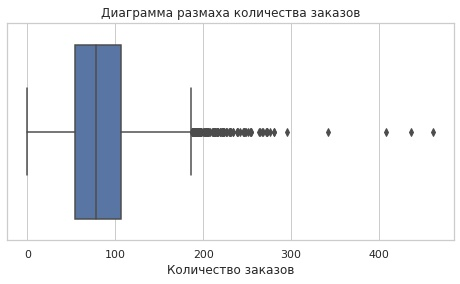

In [9]:
plt.figure(figsize=(8, 4))
ax = sns.boxplot(data=data,  x='num_orders')

# подписи графиков
show_title(title='Диаграмма размаха количества заказов',
        x_label='Количество заказов',
        y_label='',
        ax=ax)

- ***В данных присутствуют нетипично большие количества заказов такси. Однако такие заказы не выглядят невозможными, поэтому аномалии удалять не будем.***

<a id="EDA"></a>
## EDA
### Количество заказов, тренд
- **Построим график зависимости количества заказов от времени и график тренда.**

In [10]:
decomposed = seasonal_decompose(data['num_orders'])

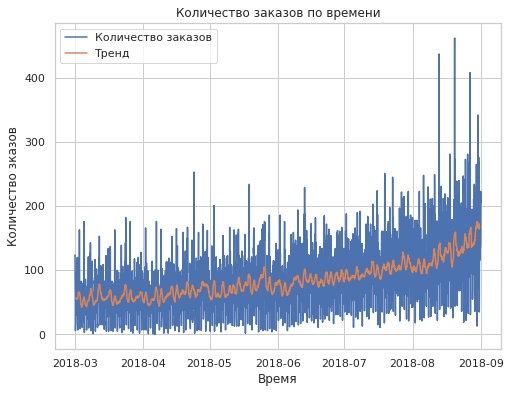

In [11]:
ax = sns.lineplot(data=data, x=data.index, y='num_orders', label='Количество заказов')
ax = sns.lineplot(data=decomposed.trend, label='Тренд')
show_title(title='Количество заказов по времени',
        x_label='Время',
        y_label='Количество зказов',
        ax=ax)

- ***Прослеживается общий тренд - с марта по август количество заказов увеличивается.***

### Сезонность по часам

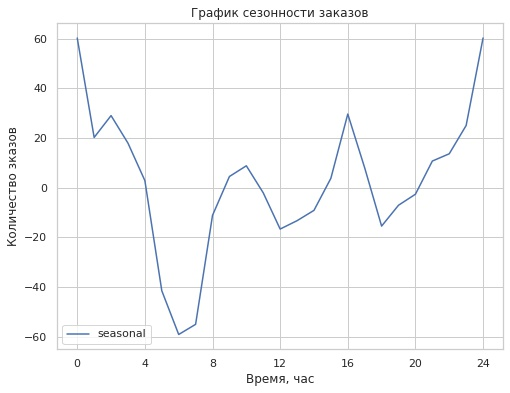

In [12]:
ax = sns.lineplot(data=decomposed
                  .seasonal['2018-03-01 00:00:00': '2018-03-02 00:00:00']
                  .reset_index()
                 )
show_title(title='График сезонности заказов',
        x_label='Время, час',
        y_label='Количество зказов',
        ax=ax)
ax.xaxis.set_major_locator(plt.MaxNLocator(8))

- ***По графику анализа сезонности заказов можно отметить, что наибольшее чесло заказов совершается ночью в районе 23:00 - 01:00 часов. Наименьшее число заказов в 5-6 утра.***

### Количество заказов от дня недели

- **Построим график зависимости количества заказов от дня недели**

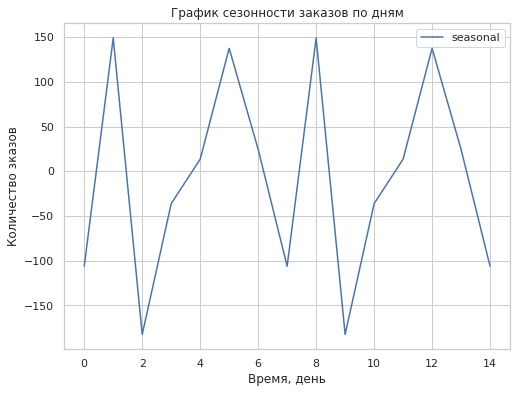

In [13]:
decomposed_day = seasonal_decompose(data.resample('1D').sum()['num_orders'])

ax = sns.lineplot(data=decomposed_day
                  .seasonal['2018-04-01 00:00:00': '2018-04-15 00:00:00'].reset_index()
                 )

show_title(title='График сезонности заказов по дням',
        x_label='Время, день',
        y_label='Количество зказов',
        ax=ax)

- ***Максимальные заказы наблюдаются с воскресенья на понедельник, так же есть рост в пятницу.***

### Cреднее количество поездок по каждому часу внутри недели

- **Построим график среднего количества поездок по каждому часу внутри недели**

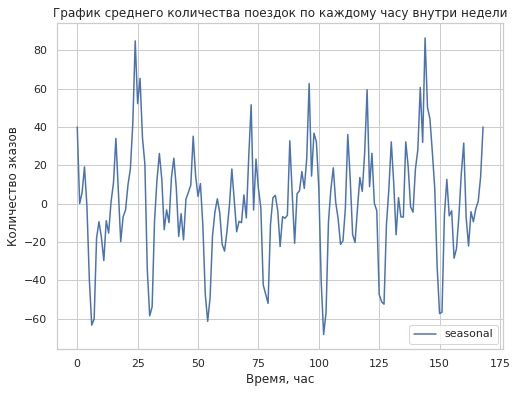

In [14]:
decomposed_hour = seasonal_decompose(data['num_orders'],
                                    period=168)

ax = sns.lineplot(data=decomposed_hour
                  .seasonal['2018-04-01 00:00:00': '2018-04-08 00:00:00'].reset_index()
                 )

show_title(title='График среднего количества поездок по каждому часу внутри недели',
        x_label='Время, час',
        y_label='Количество зказов',
        ax=ax)

- ***Максимальное количество заказов наблюдается ночью в 00 часов. Минимальное в 5 - 7 утра. В пятницу пик активности начинается раньше в 22 часа. В ночь с воскресенья на понедельник так же наблюдается пик заказов.***

### Выводы по EDA
- ***Прослеживается общий тренд - с марта по август количество заказов увеличивается.***
- ***Данные имеют суточную сезонность. По графику анализа сезонности заказов можно отметить, что наибольшее чесло заказов совершается ночью в районе 23:00 - 01:00 часов. Наименьшее число заказов в 5-6 утра.***
- ***Так же есть недельная сезонность. В пятницу и в ночь с воскресенья на понедельник заказов больше, чем в остальные дни.***
- ***Временной ряд не является стационарным, т.к. имеет восходящий тренд.***


<a id="model"></a>
## Моделирование
- **Введем новые признаки.**
- **Постоим модель для предсказания количества заказов такси на следующий час.**
- **Выберем лучшую модель из ElasticNet, DecisionTree, KNeighbors, SVM.**
- **В качестве метрики выберем RMSE. Критерий успеха RMSE < 48.**

### Создание прзнаков
- **В данных присутствует суточная и недельная сезонность. Ведем дополнительные признаки с учетом этого: `day_of_week, hour, lag, rolling_mean`**

In [15]:
def make_features(data, max_lag, rolling_mean_size):

    """
    Функция добавляет новые признаки на основе данных о времени
    """
    data = data.copy()
    # календарные признаки
    data['day_of_week'] = data.index.dayofweek
    data['hour'] = data.index.hour
    # отстающие значения
    for lag in range(1, max_lag + 1):
        data[f'lag_{lag}'] = data['num_orders'].shift(lag)
    # скользящее среднее
    data['rolling_mean'] = (data['num_orders']
                            .shift()
                            .rolling(rolling_mean_size)
                            .mean())

    return data.dropna()

In [16]:
data = make_features(data, 168, 168)
data.head(5)

,num_orders,day_of_week,hour,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,...,lag_160,lag_161,lag_162,lag_163,lag_164,lag_165,lag_166,lag_167,lag_168,rolling_mean
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-08 00:00:00,143,3,0,94.0000,127.0000,108.0000,76.0000,50.0000,99.0000,48.0000,...,34.0000,15.0000,12.0000,6.0000,43.0000,66.0000,71.0000,85.0000,124.0000,54.2262
2018-03-08 01:00:00,78,3,1,143.0000,94.0000,127.0000,108.0000,76.0000,50.0000,99.0000,...,69.0000,34.0000,15.0000,12.0000,6.0000,43.0000,66.0000,71.0000,85.0000,54.3393
2018-03-08 02:00:00,65,3,2,78.0000,143.0000,94.0000,127.0000,108.0000,76.0000,50.0000,...,64.0000,69.0000,34.0000,15.0000,12.0000,6.0000,43.0000,66.0000,71.0000,54.2976
2018-03-08 03:00:00,68,3,3,65.0000,78.0000,143.0000,94.0000,127.0000,108.0000,76.0000,...,96.0000,64.0000,69.0000,34.0000,15.0000,12.0000,6.0000,43.0000,66.0000,54.2619
2018-03-08 04:00:00,60,3,4,68.0000,65.0000,78.0000,143.0000,94.0000,127.0000,108.0000,...,30.0000,96.0000,64.0000,69.0000,34.0000,15.0000,12.0000,6.0000,43.0000,54.2738


### Pipeline

In [17]:
def make_pipeline(df, target):

    '''
    Функция готовит пайплпйн
    '''

    X = df.drop(target, axis=1)
    y = df[target]

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=TEST_SIZE, shuffle=False
    )
    
    ohe_columns = ['day_of_week', 'hour']
    num_columns = X_train.drop(ohe_columns, axis=1).columns.tolist()
    
    ohe_pipe = Pipeline(
        [('SimpleImputer_before_ohe', SimpleImputer(strategy='most_frequent')),
        ('ohe', OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False))
        ]
    )
    
    # для количественных признаков
    num_pipe = Pipeline(
        [('imputer', SimpleImputer(strategy='mean')),
        ('num', MinMaxScaler())
        ]
    )

    # для обработки всех признаков
    preprocessor = ColumnTransformer(
        [('ohe', ohe_pipe, ohe_columns),
        ('num', num_pipe, num_columns)
        ],
        remainder='passthrough'
    )

    # финальный пайплайн
    pipe_final = Pipeline(
        [('preprocessor', preprocessor),
        ('models', LinearRegression())]
    )

    return pipe_final, X_train, y_train, X_test, y_test

In [18]:
param_grid = [
    {
        'models': [DecisionTreeRegressor(random_state=RANDOM_STATE)],
        'models__max_depth': range(5, 15),
        'models__min_samples_leaf': range(1, 10),
        'preprocessor__ohe': ['passthrough']
    },

    {
        'models': [ElasticNet()],
        'models__alpha': np.linspace(0.1, 1, num=5)
    },
    
    {
        'models': [KNeighborsRegressor()],
        'models__n_neighbors': range(7, 9)
    },
    
    {
        'models': [SVR()],
        'models__kernel': ['poly', 'rbf', 'sigmoid'],
        'models__C': range(15, 25)
    }
]

### Подбор гиперпараметров и обучение

In [19]:
pipe_final, X_train, y_train, X_test, y_test = make_pipeline(data, 'num_orders')

tscv = TimeSeriesSplit(n_splits=5)

search = RandomizedSearchCV(
    pipe_final,
    param_grid,
    cv=tscv,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1,
    n_iter=100,
    verbose=2,
    random_state=RANDOM_STATE
)

search.fit(X_train, y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits
[CV] END models=DecisionTreeRegressor(random_state=42), models__max_depth=7, models__min_samples_leaf=9, preprocessor__ohe=passthrough; total time=   0.1s
[CV] END models=DecisionTreeRegressor(random_state=42), models__max_depth=7, models__min_samples_leaf=9, preprocessor__ohe=passthrough; total time=   0.2s
[CV] END models=DecisionTreeRegressor(random_state=42), models__max_depth=7, models__min_samples_leaf=9, preprocessor__ohe=passthrough; total time=   0.2s
[CV] END models=DecisionTreeRegressor(random_state=42), models__max_depth=7, models__min_samples_leaf=9, preprocessor__ohe=passthrough; total time=   0.2s
[CV] END models=DecisionTreeRegressor(random_state=42), models__max_depth=7, models__min_samples_leaf=9, preprocessor__ohe=passthrough; total time=   0.3s
[CV] END .models=SVR(), models__C=19, models__kernel=sigmoid; total time=   0.2s
[CV] END .models=SVR(), models__C=19, models__kernel=sigmoid; total time=   0.4s


RandomizedSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('ohe',
                                                                               Pipeline(steps=[('SimpleImputer_before_ohe',
                                                                                                SimpleImputer(strategy='most_frequent')),
                                                                                               ('ohe',
                                                                                                OneHotEncoder(drop='first',
                                                                                                              handle_unknown='ignore',
                                                                                                              sparse_outp...
                                         'models__min_samples_leaf': range(1, 10),
                                         'preprocessor__ohe': ['passthrough']},
                                        {'models': [ElasticNet()],
                                         'models__alpha': array([0.1  , 0.325, 0.55 , 0.775, 1.   ])},
                                        {'models': [KNeighborsRegressor()],
                                         'models__n_neighbors': range(7, 9)},
                                        {'models': [SVR()],
                                         'models__C': range(15, 25),
                                         'models__kernel': ['poly', 'rbf',
                                                            'sigmoid']}],
                   random_state=42, scoring='neg_root_mean_squared_error',
                   verbose=2)

In [20]:
result = pd.DataFrame(search.cv_results_)

result['model_name'] = result['param_models'].apply(lambda x: str(x).split('(')[0])

best_results = result[
    ['model_name', 'mean_test_score']
].groupby('model_name').agg('max').sort_values('mean_test_score', ascending=False)

best_results = best_results.rename(columns={
    'mean_test_score': 'RMSE'
})

best_results.abs()

,RMSE
model_name,
ElasticNet,24.3745
SVR,24.5660
KNeighborsRegressor,26.0117
DecisionTreeRegressor,26.9371


In [21]:
pipe_final_best = Pipeline(
                [('models', search.best_estimator_['models'])]
)

best_model_name = str(search.best_estimator_["models"]).split("(")[0]

pipe_final_best.fit(X_train, y_train)
print(f'По результатам подбора гиперпараметров на кросс валидации выбрана модель: {best_model_name}')

По результатам подбора гиперпараметров на кросс валидации выбрана модель: ElasticNet


### RMSE лучшей модели на тестовой выборке

In [22]:
y_pred = pipe_final_best.predict(X_test)
rmse = root_mean_squared_error(y_test, y_pred)

print(f'RMSE модели {best_model_name} на тестовой выборке: {round(rmse, 2)}')

RMSE модели ElasticNet на тестовой выборке: 34.26


### Анализ результатов моделирования

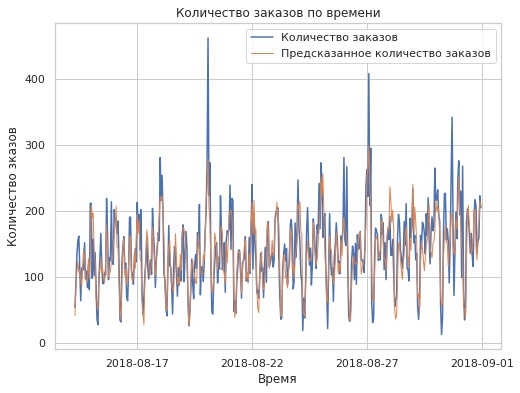

In [23]:
orders = y_test.reset_index().join(pd.DataFrame(y_pred)).set_index('datetime')
orders.columns = ['Количество заказов', 'Предсказанное количество заказов']

ax = sns.lineplot(data=orders,
                  x=orders.index,
                  y='Количество заказов',
                  label='Количество заказов')
ax = sns.lineplot(data=orders,
                  x=orders.index,
                  y='Предсказанное количество заказов',
                  label='Предсказанное количество заказов',
                  linewidth=1)

ax.xaxis.set_major_locator(plt.MaxNLocator(4))

show_title(title='Количество заказов по времени',
        x_label='Время',
        y_label='Количество зказов',
        ax=ax)

- ***По графикам действительных и предсказанных значений видно, что модель довольно точно предсказывала количество заказов до 2018-08-27. Модель уловила восходящий тренд.***
- ***Модель не предсказала случайные аномально большие значения количества заказов.***

- **Сравним RMSE модели со средним значением и сезонными эвристиками.**

In [35]:
dummy_mean = np.ones_like(y_test) * y_train.mean()
print(f"RMSE среднего значения: {round(root_mean_squared_error(y_test, dummy_mean), 3)}")

for lag in ['lag_1', 'lag_24', 'lag_168']:
    pred_previous = X_test[lag]
    print(f"RMSE {lag}: {round(root_mean_squared_error(y_test, pred_previous), 3)}")

RMSE среднего значения: 84.451
RMSE lag_1: 58.82
RMSE lag_24: 55.862
RMSE lag_168: 39.287


- ***RMSE выбранной модели лучше, чем RMSE среднего и сезонных эвристик. Значит модель работает адекватно.***

<a id="conclusion"></a>
## Выводы:
### Предобработка
- ***В результате предобработки критичных аномалий и ошибок в данных не выявлено.***
- ***Проведен ресемплинг по 1 часу.***

---

### EDA
- ***Прослеживается общий тренд - с марта по август количество заказов увеличивается.***
- ***Данные имеют суточную сезонность. По графику анализа сезонности заказов можно отметить, что наибольшее чесло заказов совершается ночью в районе 23:00 - 01:00 часов. Наименьшее число заказов в 5-6 утра.***
- ***Так же есть недельная сезонность. В пятницу и в ночь с воскресенья на понедельник заказов больше, чем в остальные дни.***
- ***Временной ряд не является стационарным, т.к. имеет восходящий тренд.***

---

### Моделирование
- ***Созданы новые признаки `day_of_week, hour, lag, rolling_mean`.***
- ***Рассмотрены 4 модели ElasticNet, DecisionTree, KNeighbors, SVM.***

In [26]:
best_results.abs()

,RMSE
model_name,
ElasticNet,24.3745
SVR,24.5660
KNeighborsRegressor,26.0117
DecisionTreeRegressor,26.9371


In [27]:
display(HTML(f"""<strong>По результатам подбора гиперпараметров
на кросс валидации выбрана модель: {best_model_name}</strong>"""))

In [28]:
display(HTML(f"""<strong>RMSE модели {best_model_name}
              на тестовой выборке: {round(rmse, 2)}</strong>"""))

- ***По графикам действительных и предсказанных значений видно, что модель довольно точно предсказывала количество заказов до 2018-08-27. Модель уловила восходящий тренд.***
- ***Модель не предсказала случайные аномально большие значения количества заказов.***
- ***RMSE выбранной модели лучше, чем RMSE среднего и сезонных эвристик. Значит модель работает адекватно.***

---

### Рекомендации
- ***Сбор дополнительных данных, которые помогут точнее определить спрос на такси, например:***
    - ***в какой аэропорт заказывают такси;***
    - ***расписание рейсов (прилеты/вылеты - так же будут влиять на пасажиропоток);***
    - ***погода;***
    - ***массовые мероприятия (возможно всплески заказов такси в данном датасете были вызваны некоторыми единичными массовыми событиями).***
- ***Периодически необходимо дообучать модель на новых данных.***
- ***Рассмотреть более сложные и специализированные для временных рядов модели, использовать нейросети.***
- ***Ввести штрафы в модели за занижение количества заказов.***